<a href="https://colab.research.google.com/github/saidamir/Udacity_StackOverflowSurvey/blob/master/Z.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

As data scientists we work with datasets that are often not well documented (i.e. data from our vehicles recorded by various teams) but the organization looks to us to provide insights.

In this exercise, please explore the included (small) data files and provide a basic analysis you would share with another data scientist in a Rmarkdown notebook or a Jupyter notebook. After your analysis you should be equipped to provide a summary to a business stakeholder
describing your findings.

Please spend no more than 4-5 hrs on this exercise. The context below may help guide you in your analysis.

# Background

The data files are from two mobility companies. We are interested in learning more about the dynamics of the market in which they operate.

1. Describe the operations of these two mobility companies.
2. Please estimate the number of scooters company b operates in this geography? Simpler mechanisms of estimation are preferred.

First of all we neex to do an EDA of datasets.
We have five 'a' files and two 'b' files and need to understand how these file are related to one another. Most probably we just need to union them.
Then we need to understand the dimensions of the data points, their statistical summary and distribution where applicable to be able to select the right approach to data.
Then, we will actually start analyzing the data and coming up with answers to specific questions or actually come up with theories on what the data tell us.

In [ ]:
import pandas as pd
import numpy as np
import math
import warnings; warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import plotly.graph_objects as go 
%matplotlib inline

In [ ]:
a1=pd.read_csv('company_a_1.csv')
a2 = pd.read_csv('company_a_2.csv')
a3 = pd.read_csv('company_a_3.csv')
a4 = pd.read_csv('company_a_4.csv')
a5 = pd.read_csv('company_a_5.csv')
b1 = pd.read_csv('company_b_1.csv')
b2 = pd.read_csv('company_b_2.csv')

In [ ]:
#all the 'a' files seem to follow the below structure and as such most probablty they should be union'd.
# However we need to check if we can safely union the files.
a1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6834 entries, 0 to 6833
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TripID          6834 non-null   object 
 1   ScooterID       6834 non-null   object 
 2   StartTime       6834 non-null   object 
 3   EndTime         6834 non-null   object 
 4   StartLatitude   6834 non-null   float64
 5   StartLongitude  6834 non-null   float64
 6   EndLatitude     6834 non-null   float64
 7   EndLongitude    6834 non-null   float64
 8   TripDistance    6834 non-null   float64
dtypes: float64(5), object(4)
memory usage: 480.6+ KB


In [ ]:
a4.describe()

,StartLatitude,StartLongitude,EndLatitude,EndLongitude,TripDistance
count,13047.000000,13047.000000,13046.000000,13046.000000,1.304700e+04
mean,38.236395,-85.751262,38.234558,-85.757119,1.037345e+02
std,0.018718,0.017140,0.077937,0.396541,1.162291e+04
min,38.100000,-85.900000,33.400000,-111.870000,-4.915000e+01
25%,38.220000,-85.760000,38.220000,-85.760000,2.300000e-01
50%,38.240000,-85.760000,38.240000,-85.760000,5.600000e-01
75%,38.250000,-85.750000,38.250000,-85.750000,1.250000e+00
max,38.280000,-85.630000,38.300000,-85.630000,1.327569e+06


In [ ]:
#lets transform time columns to datetime type from object type
dfs = [a1,a2,a3,a4,a5]
for df in dfs:
  df.StartTime = pd.to_datetime(df.StartTime)
  df.EndTime = pd.to_datetime(df.EndTime)

Tables company_a_X seem like belonging to the same dataset but with difference timing and as such should be union'd.

In [ ]:
#Lets see if Start Times correspond in aN tables
df = [a1,a2,a3,a4,a5]
for i in (df):
  print ('min', i.StartTime.min(), 'max', i.StartTime.max())

min 2018-08-09 10:24:00 max 2018-08-31 20:59:00
min 2018-09-01 06:46:00 max 2018-09-29 20:55:00
min 2018-09-30 04:52:00 max 2018-10-30 20:44:00
min 2018-11-01 07:01:00 max 2018-11-30 20:59:00
min 2018-12-01 13:13:00 max 2018-12-31 20:52:00


In [ ]:
#lets union all the tables as they seem belonging to the same data collection but broken down into five parts
a = pd.concat([a1,a2,a3,a4,a5])

In [ ]:
#it looks like there are outliers in Trip distance as it cannot be negative, or be larger than say 100 km
a.describe()

,StartLatitude,StartLongitude,EndLatitude,EndLongitude,TripDistance
count,57365.00000,57365.000000,57364.000000,57364.000000,5.736500e+04
mean,38.24342,-85.745516,38.241914,-85.745865,1.491247e+02
std,0.01614,0.020405,0.172975,0.433992,1.352164e+04
min,38.10000,-85.900000,0.000000,-122.420000,-1.034441e+04
25%,38.23000,-85.760000,38.230000,-85.760000,2.900000e-01
50%,38.25000,-85.750000,38.250000,-85.750000,7.500000e-01
75%,38.26000,-85.740000,38.260000,-85.740000,1.740000e+00
max,38.34000,-85.490000,41.300000,0.000000,1.334378e+06


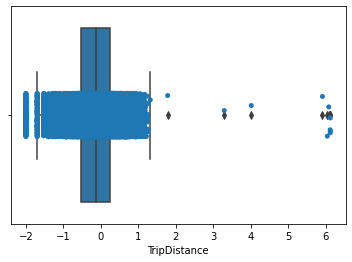

In [ ]:
#There are significant outliers and as such we need to log the data
#There are quite a few data points which are outliers and as such we will need to device an algorithm to filter out
#outliers instead of individually filtering them out
# We need to filter out the values with approx value log10>2, i.e. 100
sns.boxplot(np.log10(a['TripDistance']))
sns.stripplot(np.log10(a['TripDistance']))

In [ ]:
#lets double check the values over 50, and have only 10 datapoints
a[a.TripDistance>50]

,TripID,ScooterID,StartTime,EndTime,StartLatitude,StartLongitude,EndLatitude,EndLongitude,TripDistance
1195,d29102fa-094d-47bc-9aff-468e1a3ef8ae,55179511-3d9f-4def-b9e2-24af25712217,2018-10-01 18:32:00,2018-10-01 18:44:00,38.26,-85.73,38.25,-85.73,1111734.31
1495,5cc29f4d-b809-456d-b1ad-bdd4f58a6b30,55afb762-f8e9-4fba-ab2a-9969493e9959,2018-10-02 14:43:00,2018-10-02 15:04:00,38.24,-85.76,38.24,-85.76,1334335.28
1698,37eea201-67bc-4d9d-b1d7-fc4ec002e137,9b555b61-1aca-414b-89e2-2dba4ec7b4d1,2018-10-02 18:23:00,2018-10-02 18:43:00,38.22,-85.69,38.24,-85.69,1334377.66
5950,8fc8a42a-95d1-41e5-8497-be90a2acfb2b,83cc60dd-2323-4e12-97c6-73010a061bf9,2018-10-09 20:16:00,2018-10-09 20:40:00,38.24,-85.72,38.23,-85.72,1213527.47
11398,3bd10575-4a19-4af3-b7f4-58382f95bf52,a24e5657-6892-4842-92f0-c053b27dc659,2018-10-20 13:30:00,2018-10-20 14:25:00,38.24,-85.72,38.26,-85.76,1334328.70
12029,fa9225a2-7331-47a6-a173-445187c02a1c,bf9a5882-49f9-46f6-aca0-94474e0a3041,2018-10-21 11:25:00,2018-10-21 12:00:00,38.25,-85.74,38.25,-85.75,822605.85
159,81cbcbdb-471b-45c5-be8e-77d769a77d6c,317b92b3-d5e3-40f9-b601-30f3a88b78c7,2018-11-02 07:56:00,2018-11-02 07:57:00,38.23,-85.71,38.23,-85.71,1968.14
1476,017c5a12-bce4-4bb1-8499-4e80e55f61e8,4bc1f554-1bde-4596-b3b2-6f22a90528c8,2018-11-06 04:51:00,2018-11-06 06:28:00,38.26,-85.75,38.26,-85.75,1327569.19
8297,5b8b2a48-a934-4d16-9cf9-5a0f11ddce18,ce7ced9d-9ac4-4823-9144-ec3a89f78b26,2018-11-19 19:31:00,2018-11-19 19:34:00,38.26,-85.75,38.26,-85.75,10374.71
438,d2651b53-67db-44cc-a354-8d574d0b3613,497c7a56-8fbd-4204-b2bd-bd1128ff1b59,2018-12-02 16:13:00,2018-12-02 16:34:00,38.26,-85.73,38.25,-85.74,60.75


In [ ]:
#IQR is not very helpful as the data is skewed
#from scipy.stats import iqr
#a_iqr = a[a['TripDistance']>a.TripDistance.quantile(0.75) +1.5*iqr(a.TripDistance)]
#a_iqr.sort_values(by='TripDistance')


In [ ]:
a[a['TripDistance']<=0].sort_values(by=['TripDistance'])

,TripID,ScooterID,StartTime,EndTime,StartLatitude,StartLongitude,EndLatitude,EndLongitude,TripDistance
3189,ce2ec7ad-ae93-4e02-9c54-f2b654aabed1,f43b22b2-6338-4be1-99f2-7d1e41c72920,2018-12-09 15:30:00,2018-12-09 15:57:00,38.25,-85.74,38.27,-85.73,-10344.41
6772,6393de57-c309-4db9-9747-045771081bc0,a249c424-7e46-4fd3-bda0-55621ce9752c,2018-12-21 14:10:00,2018-12-21 14:14:00,38.25,-85.76,38.25,-85.76,-4006.68
9968,f819ea72-5267-4230-b7fc-02773710513a,98b82db4-e333-4bc4-892e-c8de7436759b,2018-09-23 19:49:00,2018-09-23 20:23:00,38.22,-85.69,38.20,-85.73,-67.79
1000,5cfed613-a0a0-4c4f-bdb0-599aed8a7b27,a8ba61b8-c670-404f-8061-d35a77938705,2018-12-04 08:07:00,2018-12-04 08:11:00,38.23,-85.76,38.23,-85.76,-60.20
430,3b6eafea-6a71-4421-ace9-fd8e35660d68,497c7a56-8fbd-4204-b2bd-bd1128ff1b59,2018-12-02 16:03:00,2018-12-02 16:13:00,38.25,-85.74,38.26,-85.73,-57.15
...,...,...,...,...,...,...,...,...,...
4369,5d9ea163-52f7-4208-9150-3d8267ea6b44,c1e4e5d6-a2a1-4415-8c9c-e03eb3a9316a,2018-10-06 18:59:00,2018-10-06 19:06:00,38.24,-85.72,38.24,-85.72,0.00
4365,5326ba51-bed7-4944-baef-0259860743ad,4049d26b-326f-4b26-b1a6-587c3806562b,2018-10-06 18:56:00,2018-10-06 18:58:00,38.24,-85.72,38.24,-85.72,0.00
4363,b0154a56-0f08-4187-845d-6a71b70386be,d0ff5259-f2c3-45c3-89bb-33bdf41ceeb0,2018-10-06 18:54:00,2018-10-06 18:55:00,38.24,-85.71,38.24,-85.71,0.00
4389,b2f8c2a6-5348-47c5-891c-3878026c2375,55afb762-f8e9-4fba-ab2a-9969493e9959,2018-10-06 19:18:00,2018-10-06 19:38:00,38.25,-85.74,38.26,-85.75,0.00


#There are more than 10% of trips with distance of 0. On 2018-10-06 there was a pick of such 0 distance trips

In [ ]:
a['TripDistance'][a['TripDistance']<=0].value_counts().head()

 0.00    6423
-0.06      11
-0.12      10
-0.25       6
-0.19       6
Name: TripDistance, dtype: int64

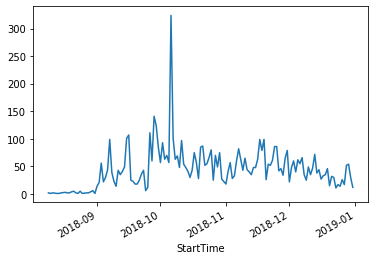

In [ ]:
#a[a.TripDistance==0] 
a_zero = a[a['TripDistance']==0]
a_zero.groupby(a_zero.StartTime.dt.to_period('D').dt.to_timestamp()).count()['TripID'].plot()
#a_norm.groupby(a_norm.StartTime.dt.to_period('W').dt.to_timestamp()).sum()['TripDistance'].plot()


In [ ]:
a_zero.groupby(a_zero.StartTime.dt.to_period('D').dt.to_timestamp()).count()['TripID'].sort_values()


StartTime
2018-08-10      1
2018-08-13      1
2018-08-14      1
2018-08-31      1
2018-08-23      1
             ... 
2018-09-16    107
2018-09-26    111
2018-09-29    124
2018-09-28    141
2018-10-06    324
Name: TripID, Length: 140, dtype: int64

In [ ]:
#Lets select all the values without outliers, this data will be used for stat summary. Most probably the 0 distance trips are those which were cancelled
a_norm = a[(a['TripDistance']>=0) & (a['TripDistance']<50)]

In [ ]:
#only 78 rows were excluded as anomalies, a bit more than 0.1%  (57365 - 57287) 
a_norm.describe()

,StartLatitude,StartLongitude,EndLatitude,EndLongitude,TripDistance
count,57287.000000,57287.000000,57286.000000,57286.000000,57287.000000
mean,38.243420,-85.745527,38.241914,-85.745875,1.371057
std,0.016142,0.020398,0.173091,0.434287,1.765037
min,38.100000,-85.900000,0.000000,-122.420000,0.000000
25%,38.230000,-85.760000,38.230000,-85.760000,0.290000
50%,38.250000,-85.750000,38.250000,-85.750000,0.750000
75%,38.260000,-85.740000,38.260000,-85.740000,1.740000
max,38.340000,-85.490000,41.300000,0.000000,20.880000


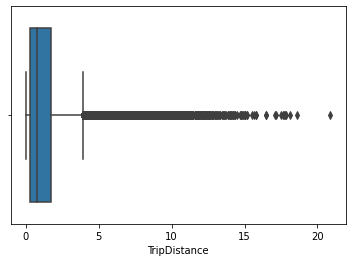

In [ ]:
sns.boxplot(a_norm.TripDistance)

# From below histograms we can see that the distribution is highly right skewed and that the mode (even though it is not discrete data) is 0 followed by 0.28. Median is 0.75


In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=a_norm.TripDistance))
fig.update_layout(yaxis_type='log')
fig.show()

In [ ]:
#sns.histplot(a_norm.TripDistance)
fig = go.Figure()
fig.add_trace(go.Histogram(x=a_norm.TripDistance, histnorm='probability', cumulative_enabled=True))
fig.update_layout(yaxis_type='log')
fig.show()

In [ ]:
print (a_norm.TripDistance.median(), a_norm.TripDistance.mode(), a_norm.TripDistance.quantile(q =0.25), a_norm.TripDistance.quantile(q=0.5), a_norm.TripDistance.quantile(q=0.75)) 

0.75 0    0.0
dtype: float64 0.29 0.75 1.74


#Below plots illustrate time series of trip length summed by Day, Week or month, as well as their count and max values. 
The last week is not a full week, because 2018-12-31 is Monday so the below chart dips for incomplete week. We will work on that


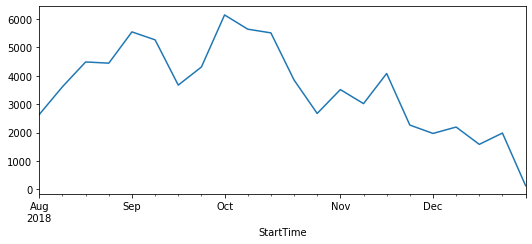

In [ ]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True


mng = plt.get_current_fig_manager()
mng.full_screen_toggle()

a_norm.groupby(a_norm.StartTime.dt.to_period('W').dt.to_timestamp()).sum()['TripDistance'].plot()
plt.show()

Plotting the 7 day average to smooth the daily plot and make sure that incomplete weeks do not distort the graph

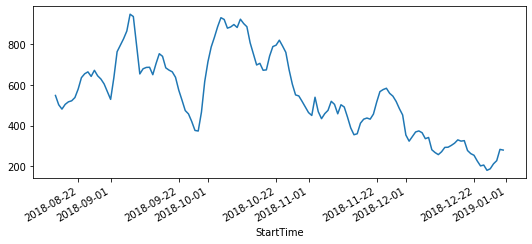

In [ ]:
a_week=a_norm.groupby(a_norm.StartTime.dt.to_period('D').dt.to_timestamp()).sum()['TripDistance']
a_week.head()
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True


mng = plt.get_current_fig_manager()
mng.full_screen_toggle()
a_week.rolling(window=7).mean().plot()

Weekly sum and counts of trips follow similar trajectory, however starting November there were some changes as we started seeing larger number of trips than their length

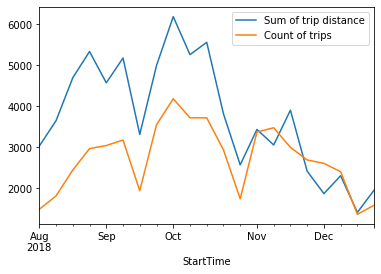

In [ ]:
fig, ax=plt.subplots()
a_norm.groupby(a_norm.StartTime.dt.to_period('W-MON').dt.to_timestamp()).sum()['TripDistance'].plot(legend=True)
a_norm.groupby(a_norm.StartTime.dt.to_period('W-MON').dt.to_timestamp()).count()['TripDistance'].plot(legend=True)
ax.legend(['Sum of trip distance','Count of trips'])


The sum of trip distance seriously dips towards the last week compared to the median and max trip distance. What was driving this decline? Median trip lenght, trip count?

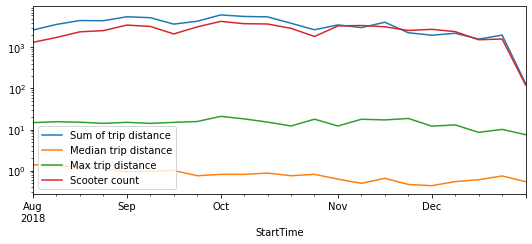

In [ ]:
#a_norm.groupby('StartTime').sum()['TripDistance'].plot()

fig, ax=plt.subplots()
a_norm.groupby(a_norm.StartTime.dt.to_period('W').dt.to_timestamp()).sum()['TripDistance'].plot(logy=True)
a_norm.groupby(a_norm.StartTime.dt.to_period('W').dt.to_timestamp()).median()['TripDistance'].plot(logy=True)
a_norm.groupby(a_norm.StartTime.dt.to_period('W').dt.to_timestamp()).max()['TripDistance'].plot(logy=True)
a_norm.groupby(a_norm.StartTime.dt.to_period('W').dt.to_timestamp()).count()['ScooterID'].plot(logy=True)
ax.legend(['Sum of trip distance','Median trip distance','Max trip distance','Scooter count'])
#a_norm.groupby(a_norm.StartTime.dt.to_period('W').dt.to_timestamp()).sum()['TripDistance']/ a_norm.groupby(a_norm.StartTime.dt.to_period('W').dt.to_timestamp()).count()['TripDistance'].plot()


Median trip distance at the end was above average

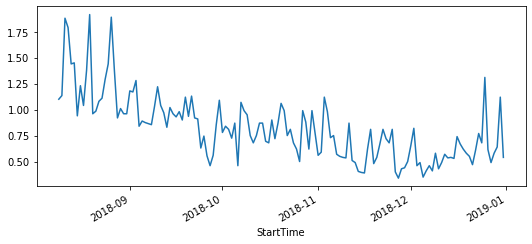

In [ ]:
a_norm.groupby(a_norm.StartTime.dt.to_period('D').dt.to_timestamp()).median()['TripDistance'].plot()

There are definetely less trips during the last week.

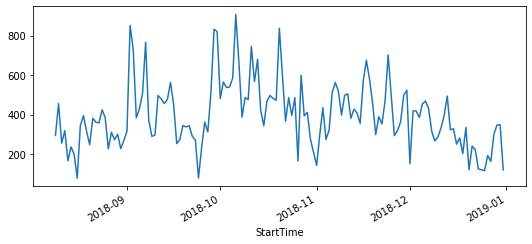

In [ ]:
a_norm.groupby(a_norm.StartTime.dt.to_period('D').dt.to_timestamp()).count()['TripDistance'].plot()

Unique count of scooters was oscillating however had increasing trend

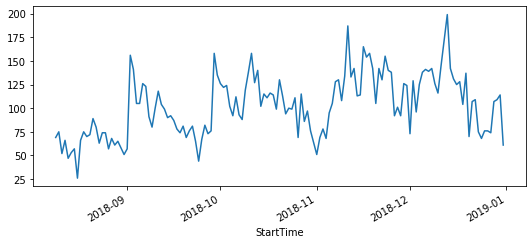

In [ ]:
a_norm.groupby(a_norm.StartTime.dt.to_period('D').dt.to_timestamp()).nunique()['ScooterID'].plot()

#Lets see the average distance of trips for each scooter.
The average trip lenght declines however it was picking up in December.

The average trip summary stats: mean 1.38 median 1.39 stddev 0.48 CI_lower 0.42 CI_upper 2.33

The average trip per each unique scooter: mean 5.64 median 5.56 stddev 2.94 CI_lower -0.24 CI_upper 11.53. We can't really use confidence intervals here as the data is not normally distributed.



As you can see from below graph, the average trip for scooter per day is significantly oscillating compared to the average trip per day

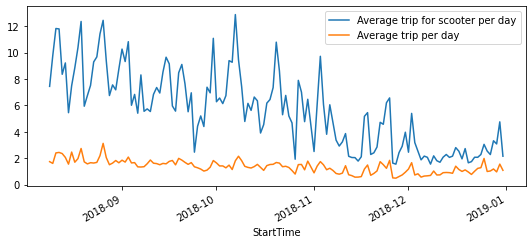

In [ ]:
a_norm_aver_trip_scooter = a_norm.groupby(a_norm.StartTime.dt.to_period('D').dt.to_timestamp()).sum()['TripDistance']/a_norm.groupby(a_norm.StartTime.dt.to_period('D').dt.to_timestamp()).nunique()['ScooterID']
a_norm_aver_trip = a_norm.groupby(a_norm.StartTime.dt.to_period('D').dt.to_timestamp()).sum()['TripDistance']/a_norm.groupby(a_norm.StartTime.dt.to_period('D').dt.to_timestamp()).count()['TripDistance']
a_norm_aver_trip.head()
fig, ax=plt.subplots()
a_norm_aver_trip_scooter.plot()
a_norm_aver_trip.plot()
ax.legend(['Average trip for scooter per day','Average trip per day'])

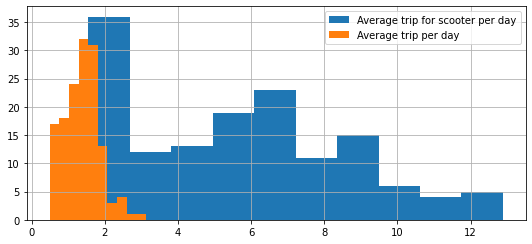

In [ ]:
fig, ax=plt.subplots()
a_norm_aver_trip_scooter.hist()
a_norm_aver_trip.hist()
ax.legend(['Average trip for scooter per day','Average trip per day'])
plt.show()

In [ ]:
print('Average trip for scooter per day')
print ('mean', a_norm_aver_trip_scooter.mean(), 'median', a_norm_aver_trip_scooter.median(),'stddev', a_norm_aver_trip_scooter.std(),'CI_lower', a_norm_aver_trip_scooter.mean()-2*a_norm_aver_trip_scooter.std(),'CI_upper',a_norm_aver_trip_scooter.mean()+2*a_norm_aver_trip_scooter.std())
print('Average trip per day')
print ('mean', a_norm_aver_trip.mean(), 'median', a_norm_aver_trip.median(),'stddev', a_norm_aver_trip.std(),'CI_lower', a_norm_aver_trip.mean()-2*a_norm_aver_trip.std(),'CI_upper',a_norm_aver_trip.mean()+2*a_norm_aver_trip.std())

Average trip for scooter per day
mean 5.64249532490954 median 5.562540095040095 stddev 2.9427355490165334 CI_lower -0.24297577312352647 CI_upper 11.527966422942608
Average trip per day
mean 1.3782602446619754 median 1.3941064138507704 stddev 0.4771106490488198 CI_lower 0.42403894656433583 CI_upper 2.332481542759615


#Lets try to visualize the data on the map
The scooters are located in Louisville, KY.

In [ ]:
#install geopython libraries
!apt install gdal-bin python-gdal python3-gdal
#install python3-rtree - Geopandas requirement
!apt install python3-rtree 
#install geopandas
!pip install git+git://github.com/geopandas/geopandas.git
#install descartes - Geopandas requirement
!pip install descartes

Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
The following additional packages will be installed:
  python3-numpy
Suggested packages:
  python-numpy-doc python3-nose python3-numpy-dbg
The following NEW packages will be installed:
  python3-gdal python3-numpy
0 upgraded, 2 newly installed, 0 to remove and 37 not upgraded.
Need to get 2,288 kB of archives.
After this operation, 13.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-numpy amd64 1:1.13.3-2ubuntu1 [1,943 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python3-gdal amd64 2.2.3+dfsg-2 [346 kB]
Fetched 2,288 kB in 1s (2,208 kB/s)
Selecting previously unselected package python3-numpy.
(Reading database ... 155047 files and directories currently installed.)
Preparing to unpack .../python3-numpy_

In [ ]:
!pip install cartopy
import cartopy

     |████████████████████████████████| 10.8 MB 4.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 12.1 MB 12.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 219 kB 55.2 MB/s 
  Created wheel for cartopy: filename=Cartopy-0.19.0.post1-cp37-cp37m-linux_x86_64.whl size=12516273 sha256=881cce491a654b7c75de6d4604861cd3eec348bc534cdf3552cde6ef873f48bc
  Stored in directory: /root/.cache/pip/wheels/98/01/f7/bd10aeb96fe4b518cde5f7c4f5e12c7202f85b7353a5017847
  Created wheel for pyshp: filename=pyshp-2.1.3-py3-none-any.whl size=37325 sha256=39655877c6731fa9a7f352c78cf7673fd7f3f4f5ecce698e4bb96e9a227d94ca
  Stored in directory: /root/.cache/pip/wheels/43/f8/87/53c8cd41545ba20e536ea29a8fcb5431b5f477ca50d5dffbbe
Successfully built cartopy pyshp


In [ ]:
import geopandas as gpd
from shapely.geometry import Point
from cartopy import crs as ccrs



In [ ]:
a_geo = gpd.GeoDataFrame(
    a_norm, geometry=gpd.points_from_xy(a_norm.StartLongitude, a_norm.StartLatitude))

In [ ]:
a_geo.head()

,TripID,ScooterID,StartTime,EndTime,StartLatitude,StartLongitude,EndLatitude,EndLongitude,TripDistance,geometry
0,0e56a534-66f4-448b-8eaa-beab76509955,5bc901d7-b714-4c57-a614-3d7193da825a,2018-08-09 10:24:00,2018-08-09 10:26:00,38.25,-85.76,38.25,-85.76,0.04,POINT (-85.76000 38.25000)
1,d9280fb0-8135-4750-9c71-c610789ba005,3d1905ec-85be-4773-9fe2-34421073363f,2018-08-09 10:26:00,2018-08-09 10:56:00,38.25,-85.74,38.26,-85.77,1.98,POINT (-85.74000 38.25000)
2,48fa27f3-3b19-4f0e-8665-ee0b188445fd,5bc901d7-b714-4c57-a614-3d7193da825a,2018-08-09 10:26:00,2018-08-09 10:35:00,38.25,-85.76,38.25,-85.76,0.06,POINT (-85.76000 38.25000)
3,6321b580-9055-4418-8c17-1d39a4d49027,4d49088f-4038-4dfb-9d55-e58a157d56d5,2018-08-09 10:37:00,2018-08-09 10:56:00,38.25,-85.74,38.26,-85.77,1.85,POINT (-85.74000 38.25000)
4,d05bf0bb-f6ee-489e-a32c-a93e15b626f8,e398ff1b-5d6b-4f15-b493-a988c7ab07b6,2018-08-09 10:41:00,2018-08-09 10:47:00,38.26,-85.75,38.26,-85.76,0.35,POINT (-85.75000 38.26000)


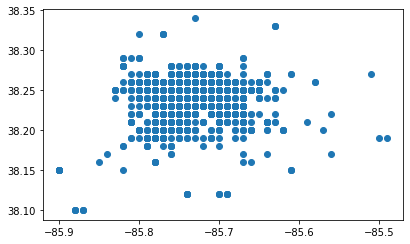

In [ ]:
a_geo.plot()


#Lets work with b data set and apply the same principles as above

In [ ]:
b1=pd.read_csv('company_b_1.csv')
b2 = pd.read_csv('company_b_2.csv')

In [ ]:
b1.describe()

,trip_id,distance_meters,start_latitude,start_longitude,end_latitude,end_longitude
count,4.088000e+03,4088.000000,4088.000000,4088.000000,4088.000000,4088.000000
mean,2.896708e+07,1794.685665,38.238948,-85.750947,38.241906,-85.700010
std,1.744291e+06,2499.671699,0.018311,0.018025,0.353339,2.487676
min,2.626508e+07,0.000000,38.090000,-85.810000,26.120000,-121.890000
25%,2.730343e+07,526.750000,38.220000,-85.760000,38.220000,-85.760000
50%,2.898439e+07,1096.000000,38.240000,-85.760000,38.240000,-85.760000
75%,3.049013e+07,2223.250000,38.260000,-85.750000,38.250000,-85.750000
max,3.193945e+07,100000.000000,38.320000,-85.560000,48.860000,2.360000


In [ ]:
b1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4088 entries, 0 to 4087
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   trip_id          4088 non-null   int64  
 1   start_time       4088 non-null   object 
 2   completed_time   4088 non-null   object 
 3   distance_meters  4088 non-null   int64  
 4   start_latitude   4088 non-null   float64
 5   start_longitude  4088 non-null   float64
 6   end_latitude     4088 non-null   float64
 7   end_longitude    4088 non-null   float64
dtypes: float64(4), int64(2), object(2)
memory usage: 255.6+ KB


In [ ]:
dfs = [b1,b2]
for df in dfs:
  df.start_time = pd.to_datetime(df.start_time)
  df.completed_time = pd.to_datetime(df.completed_time)

In [ ]:
dfs = [b1,b2]
for df in (dfs):
  print ('min', df.start_time.min(), 'max', df.start_time.max())
  print ('min', df.completed_time.min(), 'max', df.completed_time.max())

min 2018-12-01 02:10:04+00:00 max 2018-12-31 23:57:27+00:00
min 2018-12-01 02:23:07+00:00 max 2019-01-01 01:14:33+00:00
min 2019-01-01 00:00:21+00:00 max 2019-01-31 23:34:19+00:00
min 2019-01-01 00:02:01+00:00 max 2019-02-01 00:05:26+00:00


In [ ]:
b = pd.concat([b1,b2])

In [ ]:
b.describe()

,trip_id,distance_meters,start_latitude,start_longitude,end_latitude,end_longitude
count,1.057800e+04,10578.000000,10578.000000,10578.000000,10578.000000,10578.000000
mean,3.250132e+07,1486.692759,38.233344,-85.753961,38.232768,-85.738549
std,3.244806e+06,2203.422186,0.018315,0.014404,0.286526,1.587107
min,2.626508e+07,0.000000,38.090000,-85.810000,19.420000,-121.890000
25%,2.977741e+07,479.000000,38.220000,-85.760000,38.220000,-85.760000
50%,3.303032e+07,913.000000,38.230000,-85.760000,38.230000,-85.760000
75%,3.500597e+07,1754.000000,38.250000,-85.750000,38.250000,-85.750000
max,3.760439e+07,100000.000000,38.320000,-85.560000,48.860000,2.360000


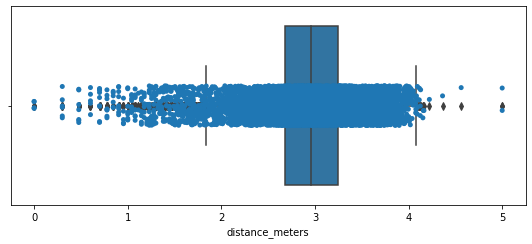

In [ ]:
sns.boxplot(np.log10(b['distance_meters']))
sns.stripplot(np.log10(b['distance_meters']))

Lets filter out outliers

In [ ]:
b_norm = b[(b['distance_meters']>=0) & (b['distance_meters']<100000)]

In [ ]:
b_norm.describe()

,trip_id,distance_meters,start_latitude,start_longitude,end_latitude,end_longitude
count,1.057600e+04,10576.000000,10576.000000,10576.000000,10576.000000,10576.000000
mean,3.250111e+07,1468.063162,38.233342,-85.753961,38.232766,-85.738546
std,3.244849e+06,1737.873333,0.018315,0.014405,0.286553,1.587257
min,2.626508e+07,0.000000,38.090000,-85.810000,19.420000,-121.890000
25%,2.977691e+07,478.750000,38.220000,-85.760000,38.220000,-85.760000
50%,3.303032e+07,913.000000,38.230000,-85.760000,38.230000,-85.760000
75%,3.500596e+07,1752.500000,38.250000,-85.750000,38.250000,-85.750000
max,3.760439e+07,36461.000000,38.320000,-85.560000,48.860000,2.360000


Lets compare datasets a and b

## Create one factor ANOVA for distance!!! Have data on the same plot

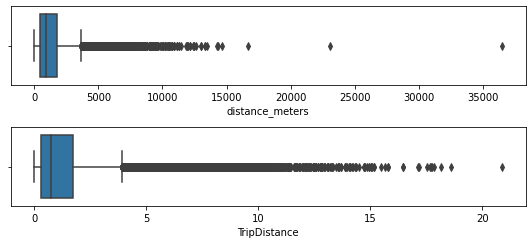

In [ ]:
fig, ax =plt.subplots(2,1)
sns.boxplot(b_norm.distance_meters, orient='h', ax=ax[0])
sns.boxplot(a_norm.TripDistance, orient='h', ax=ax[1])


There are quite a few trips with >10K distance, namely 51 of them.

In [ ]:
b_norm[b_norm['distance_meters']>10000].describe()

,trip_id,distance_meters,start_latitude,start_longitude,end_latitude,end_longitude
count,5.100000e+01,51.000000,51.000000,51.000000,51.000000,51.000000
mean,2.961224e+07,12254.490196,38.237059,-85.749804,38.231961,-85.739216
std,2.879189e+06,4074.756844,0.018471,0.017377,0.029053,0.041272
min,2.640375e+07,10012.000000,38.210000,-85.760000,38.140000,-85.810000
25%,2.656025e+07,10468.500000,38.220000,-85.760000,38.220000,-85.760000
50%,2.918950e+07,11141.000000,38.240000,-85.760000,38.240000,-85.760000
75%,3.207942e+07,12435.500000,38.260000,-85.750000,38.255000,-85.735000
max,3.630192e+07,36461.000000,38.260000,-85.680000,38.260000,-85.620000


60% of our trips in b and 30% in a have unchanged start and end longitute and lattitude coordinates, while the trip distance equals 0 and we need to decide whether to exclude those trips as bugs. However, it looks like they relate to pretty short trips, so we will not delete this data

In [ ]:
b_norm[(b_norm.start_latitude == b_norm.end_latitude) & (b_norm.start_longitude == b_norm.end_longitude)]

,trip_id,start_time,completed_time,distance_meters,start_latitude,start_longitude,end_latitude,end_longitude
3,26559594,2018-12-02 12:42:16+00:00,2018-12-02 12:56:58+00:00,1575,38.26,-85.76,38.26,-85.76
5,26548314,2018-12-02 11:46:54+00:00,2018-12-02 12:51:18+00:00,4626,38.25,-85.76,38.25,-85.76
6,26550606,2018-12-02 11:57:50+00:00,2018-12-02 12:07:22+00:00,1164,38.22,-85.76,38.22,-85.76
8,26559205,2018-12-02 12:40:16+00:00,2018-12-02 12:48:09+00:00,571,38.22,-85.76,38.22,-85.76
9,26556197,2018-12-02 12:25:39+00:00,2018-12-02 12:50:56+00:00,3293,38.24,-85.73,38.24,-85.73
...,...,...,...,...,...,...,...,...
6479,36567516,2019-01-26 13:08:58+00:00,2019-01-26 13:19:27+00:00,883,38.26,-85.75,38.26,-85.75
6481,32369635,2019-01-03 17:28:23+00:00,2019-01-03 17:30:42+00:00,10,38.25,-85.73,38.25,-85.73
6482,32778691,2019-01-05 22:04:55+00:00,2019-01-05 22:43:09+00:00,2932,38.22,-85.76,38.22,-85.76
6483,32779596,2019-01-05 22:15:18+00:00,2019-01-05 22:41:52+00:00,2724,38.22,-85.76,38.22,-85.76


Lets see what happened in a dataset

In [ ]:
a_norm[(a_norm.StartLatitude == a_norm.EndLatitude) & (a_norm.StartLongitude == a_norm.EndLongitude)]

,TripID,ScooterID,StartTime,EndTime,StartLatitude,StartLongitude,EndLatitude,EndLongitude,TripDistance,geometry
0,0e56a534-66f4-448b-8eaa-beab76509955,5bc901d7-b714-4c57-a614-3d7193da825a,2018-08-09 10:24:00,2018-08-09 10:26:00,38.25,-85.76,38.25,-85.76,0.04,POINT (-85.76000 38.25000)
2,48fa27f3-3b19-4f0e-8665-ee0b188445fd,5bc901d7-b714-4c57-a614-3d7193da825a,2018-08-09 10:26:00,2018-08-09 10:35:00,38.25,-85.76,38.25,-85.76,0.06,POINT (-85.76000 38.25000)
5,43e4d861-d8e0-4c90-9c54-dcf05073c9e0,cc1df8d9-2b1d-4bdd-b0c7-46a3c147b0c5,2018-08-09 10:41:00,2018-08-09 10:45:00,38.26,-85.75,38.26,-85.75,0.26,POINT (-85.75000 38.26000)
6,9f1a20e8-0340-450d-b5c8-76e2ef1b89f4,560c78fc-cce7-45fb-8e84-9056e2350196,2018-08-09 10:41:00,2018-08-09 10:43:00,38.25,-85.76,38.25,-85.76,0.02,POINT (-85.76000 38.25000)
7,0d5d6b31-f3d0-483b-bfea-cce538fdd2eb,90ad2ac5-3cfa-4fa9-a4cf-faa4d5087485,2018-08-09 10:42:00,2018-08-09 13:35:00,38.25,-85.76,38.25,-85.76,8.96,POINT (-85.76000 38.25000)
...,...,...,...,...,...,...,...,...,...,...
8974,b9913029-8e16-4cfa-ac1b-45809e6532e6,140db93a-532f-4254-a0c0-b4eedc643431,2018-12-31 20:38:00,2018-12-31 20:59:00,38.25,-85.76,38.25,-85.76,1.77,POINT (-85.76000 38.25000)
8975,89321b97-1319-4512-9b1f-8ce098c39eca,123d56b2-9528-486d-9f0c-41b24663f788,2018-12-31 20:42:00,2018-12-31 20:43:00,38.23,-85.71,38.23,-85.71,0.00,POINT (-85.71000 38.23000)
8977,c52348ba-a5af-4d86-a9ac-bb8dc8e68c86,8ff0800a-a99e-4db3-99ff-e4fb01506b09,2018-12-31 20:48:00,2018-12-31 20:59:00,38.23,-85.71,38.23,-85.71,0.63,POINT (-85.71000 38.23000)
8979,ede0673d-9e03-4205-bcc3-3be9a8d39f6a,dfa1518e-77be-4847-97cc-3dbc5348ee26,2018-12-31 20:51:00,2018-12-31 21:00:00,38.22,-85.75,38.22,-85.75,0.39,POINT (-85.75000 38.22000)


In [ ]:
b_norm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10576 entries, 0 to 6489
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   trip_id          10576 non-null  int64              
 1   start_time       10576 non-null  datetime64[ns, UTC]
 2   completed_time   10576 non-null  datetime64[ns, UTC]
 3   distance_meters  10576 non-null  int64              
 4   start_latitude   10576 non-null  float64            
 5   start_longitude  10576 non-null  float64            
 6   end_latitude     10576 non-null  float64            
 7   end_longitude    10576 non-null  float64            
dtypes: datetime64[ns, UTC](2), float64(4), int64(2)
memory usage: 743.6 KB


Below is the distribution of 0 length trip counts over time series. There is nothing extraordinary here, such trips are more or less distributed evenly over time, however there are more 0 trips at certain periods like mid-December and end-January. As such, there appears not to be any systematic breakage (like software bug) which happened over specific time. 

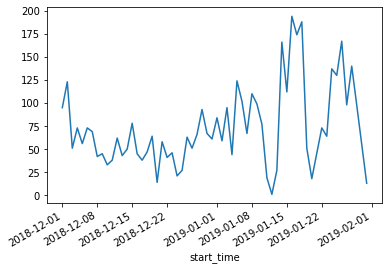

In [ ]:
b_norm_0 = b_norm[(b_norm.start_latitude == b_norm.end_latitude) & (b_norm.start_longitude == b_norm.end_longitude)]
b_norm_0.groupby(b_norm_0.start_time.dt.to_period('D').dt.to_timestamp()).count()['trip_id'].plot()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=b_norm.distance_meters))
fig.update_layout(yaxis_type='log')
fig.show()

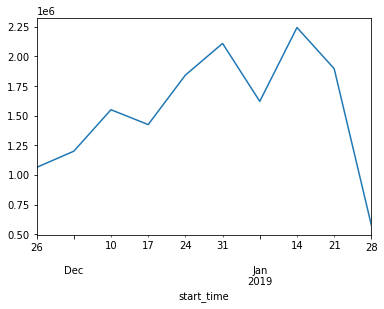

In [ ]:
#this is not a full week, because 2019-02-01 is Friday so the below chart dips for incomplete week. 
# we may plot the chart without this week.
b_norm.groupby(b_norm.start_time.dt.to_period('W').dt.to_timestamp()).sum()['distance_meters'].plot()


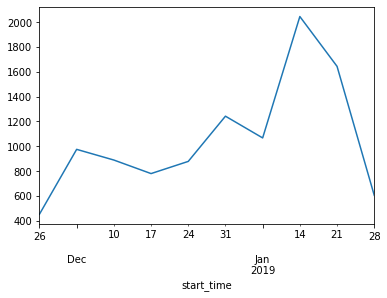

In [ ]:
#Lets see if the number of trips changed as
#this is not a full week, because 2019-02-01 is Friday so the below chart dips for incomplete week. 
# we may plot the chart without this week.
b_norm.groupby(b_norm.start_time.dt.to_period('W').dt.to_timestamp()).count()['trip_id'].plot()

# How we determine the number of scooters?
It will take long time to create graph of trips based on time and geo locations, however it will take too much time to implement (code complexity) and quite a few assumptions to make.
Even if we implement the algorithm, how can we be sure in the number of scooters held by the company? We cannot assume that the same scooters operate each day. Most probably there is technical service where some scooters are idle. Also, some companies hold more scooters to ensure that their max load capacity is met. 
As such, we may want to extrapolate information from company A. 
1. If company A and company B are similar in their metrics
2. We can extrapoliate the number of scooters in company A on company B based on the number of trips per day OR
2. We can defined the average count of non 0 trips for scooter out of all available scooters  for company A. We can also define confidence intervals OR
2a.  We can calculate the average length of a trip per scooter per day
3. Then apply the above to company B

Lets compare average trip per day stat summary for two companies to see if there is similarity. They are pretty similar

In [ ]:
b_norm_aver_trip = b_norm.groupby(b_norm.start_time.dt.to_period('D').dt.to_timestamp()).sum()['distance_meters']/b_norm.groupby(b_norm.start_time.dt.to_period('D').dt.to_timestamp()).count()['distance_meters']

print('Average trip per day, company a')
print ('mean', a_norm_aver_trip.mean(), 'median', a_norm_aver_trip.median(),'stddev', a_norm_aver_trip.std(),'CI_lower', a_norm_aver_trip.mean()-2*a_norm_aver_trip.std(),'CI_upper',a_norm_aver_trip.mean()+2*a_norm_aver_trip.std())
print('Average trip per day, company b')
print ('mean', b_norm_aver_trip.mean(), 'median', b_norm_aver_trip.median(),'stddev', b_norm_aver_trip.std(),'CI_lower', b_norm_aver_trip.mean()-2*b_norm_aver_trip.std(),'CI_upper',b_norm_aver_trip.mean()+2*b_norm_aver_trip.std())

Average trip per day, company a
mean 1.3782602446619754 median 1.3941064138507704 stddev 0.4771106490488198 CI_lower 0.42403894656433583 CI_upper 2.332481542759615
Average trip per day, company b
mean 1582.1068749995602 median 1530.846625766871 stddev 530.3220725403106 CI_lower 521.462729918939 CI_upper 2642.7510200801817


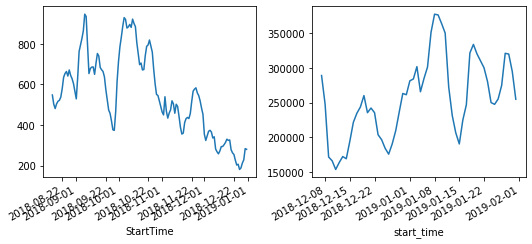

In [ ]:
#fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
plt.subplot(1, 2, 1)
#sns.boxplot(b_norm.distance_meters, ax=ax[0])
a_week=a_norm.groupby(a_norm.StartTime.dt.to_period('D').dt.to_timestamp()).sum()['TripDistance']
b_week=b_norm.groupby(b_norm.start_time.dt.to_period('D').dt.to_timestamp()).sum()['distance_meters']
a_week_roll=a_week.rolling(window=7).mean()
b_week_roll = b_week.rolling(window=7).mean()
a_week_roll.plot()
plt.subplot(1, 2, 2)
b_week_roll.plot()


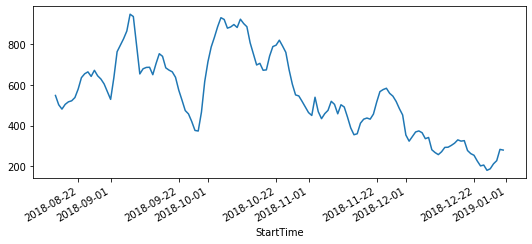

In [ ]:
a_week_roll.plot()

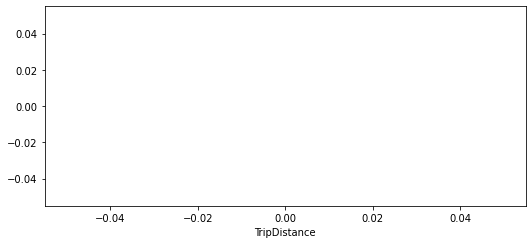

In [ ]:
sns.lineplot(a_week.rolling(window=7).mean())


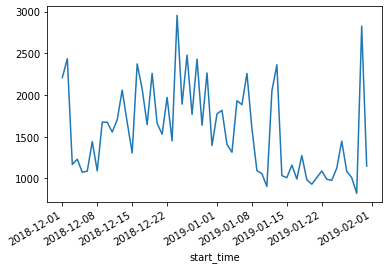

In [ ]:
trip_dist=b_norm.groupby(b_norm.start_time.dt.to_period('D').dt.to_timestamp()).sum()['distance_meters'] 
trip_count = b_norm.groupby(b_norm.start_time.dt.to_period('D').dt.to_timestamp()).count()['trip_id']
avg_trip = trip_dist/trip_count
avg_trip.plot()


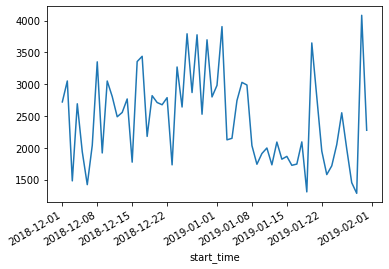

In [ ]:
#trip distance over days
trip_dist_sans0=b_norm_sans0.groupby(b_norm_sans0.start_time.dt.to_period('D').dt.to_timestamp()).sum()['distance_meters'] 
#trip count over days
trip_count_sans0 = b_norm_sans0.groupby(b_norm_sans0.start_time.dt.to_period('D').dt.to_timestamp()).count()['trip_id']
avg_trip_sans0 = trip_dist_sans0/trip_count_sans0
avg_trip_sans0.plot()

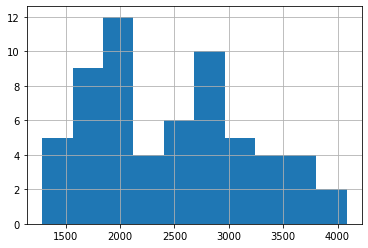

In [ ]:
avg_trip_sans0.hist()

In [ ]:
#what is the the average non zero trip stats for the whole period?
trip_count_sans0.mean(), avg_trip_sans0.std()

(2453.557296990312, 715.4090734407391)

In [ ]:
b_norm_sans0['distance_meters'].mean()/avg_trip_sans0.mean()

0.9695943351242974

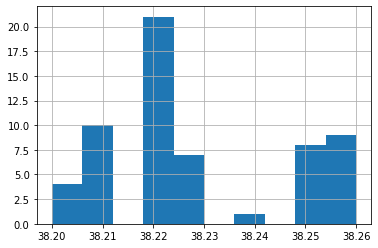

In [ ]:
b_norm_sans0['start_latitude'][b_norm_sans0.start_time.dt.to_period('D').dt.to_timestamp()=='2019-01-15'].hist()

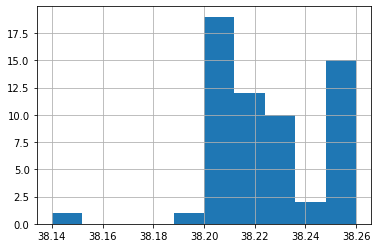

In [ ]:
b_norm_sans0['end_latitude'][b_norm_sans0.start_time.dt.to_period('D').dt.to_timestamp()=='2019-01-15'].hist()

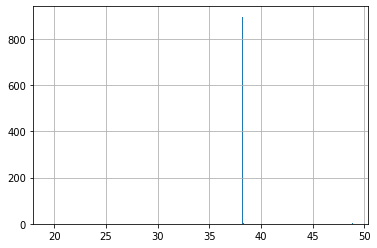

In [ ]:
b_norm_sans0['end_latitude'].hist(bins=1000)

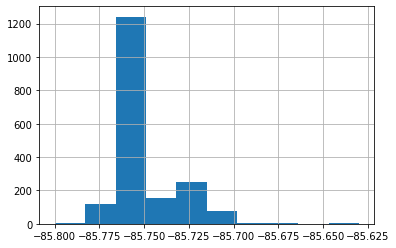

In [ ]:
b_norm_sans0['start_longitude'].hist()

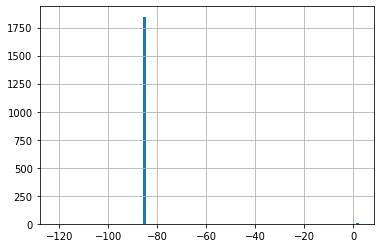

In [ ]:
b_norm_sans0['end_longitude'].hist(bins=100)